In [5]:
import numpy as np
from mindquantum.core.gates import X, H, Z, RX, RY, RZ, CNOT
from mindquantum.core.gates import Measure
from mindquantum.core.circuit import Circuit
from IPython.display import display_svg

## 模块化设计量子线路

In [2]:
def create_EPR_state(p: int, q: int) -> Circuit:
    """制备EPR Pair
    Args:
        p: 贝尔态作用第1个位置
        q: 贝尔态作用第2个位置
    Return:
        制备贝尔态线路
    """
    return Circuit([
        H(p),
        X(q, p)
    ])

def create_random_state(p: int) -> Circuit:
    """在1个比特上制备随机态，通过随机旋转初态制备
    Args:
        p: 随机值作用比特
    Return:
        处于随机的单量子态
    """
    # 使用RX, RY, RZ随机旋转角度作用在 |0> 上实现随机状态制备
    t1, t2, t3 = 2 * np.pi * np.random.random(size=3)
    return Circuit([
        RX(t1).on(p), # 不使用函数 on() 直接使用 RX(t1)(p) 也可
        RY(t2).on(p),
        RZ(t3).on(p)
    ])

def create_basic_module(p: int, q: int) -> Circuit:
    """CNOT,H,Measure 的组合在本位量子通信经常用到，综合为一个接口
    Args:
        p: 第1个量子位置
        q: 第2个量子位置
    Return:
        量子线路模块
    """
    return Circuit([
        CNOT(q, p),
        H(p),
        Measure(f'q{p}').on(p),
        Measure(f'q{q}').on(q)
    ])

In [3]:
def get_measure_result(ket_str: str, idx: int or list) -> int or list:
    """获取指定状态的测量结果，通过解析 get_qs(ket=True) 的返回值实现
    Args:
        ket_str: get_qs(ket=True)获取的量子态
        idx: 需要获取的量子位
    Return:
        指定量子位的测量结果，
    """
    ket_str2 = ket_str.split('\n')[0]
    if isinstance(idx, int):
        new_idx = -idx - 2
        return ket_str2[new_idx]
    if isinstance(idx, list):
        return [ket_str2[-i-2] for i in idx]
    print("Error: idx should be int or list!")
    return -1

## 论文线路复现

### 案例1

- Fig.3 量子瞬时传输线路

<img src="images/fig3.jpg" width=400>

Fig.3
complete circuit:



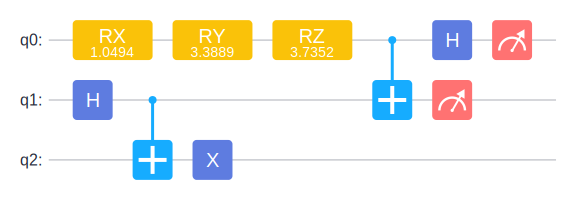

Measure result:
q0=0, q1=1

Send state ¦qn,...,q0⟩:
(0.5066002050174433-0.043308464530512736j)¦0⟩
(-0.3102524129481916+0.8032583951855832j)¦1⟩

Recv state ¦qn,...,q0⟩:
(0.5066002050174432-0.043308464530512736j)¦010⟩
(-0.3102524129481916+0.8032583951855832j)¦110⟩



In [6]:
def simulate_fig3():
    """复现论文 Fig3 的线路，实现 EPR 传输
    """
    cir_send = create_random_state(0)      # 初始需要传输的态，对应论文中 |y>
    cir_epr12 = create_EPR_state(1, 2)    # 制备 EPR
    cir_mod01 = create_basic_module(0, 1)  # 线路

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff)            # 随机数种子
    cir_all = cir_send + cir_epr12 + cir_mod01  # 量子线路
    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0, q1测量结果，保存在c0, c1
    c0, c1 = get_measure_result(ket_str, [0, 1])
    # 根据测量结果判断是否加入 X 或 Z 门
    if c1 == '1':
        cir_all += X(2)
    if c0 == '1':
        cir_all += Z(2)

    send_state = cir_send.get_qs(ket=True, seed=seed)
    recv_state = cir_all.get_qs(ket=True, seed=seed)

    print(f'Fig.3\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'Measure result:\nq0={c0}, q1={c1}\n')
    print(f'Send state ¦qn,...,q0⟩:\n{send_state}\n')
    print(f'Recv state ¦qn,...,q0⟩:\n{recv_state}\n')


simulate_fig3()

---

### 案例2

- Fig.5 量子中间方案线路

<img src="images/fig5.jpg" width=400>

Fig.5
complete circuit:



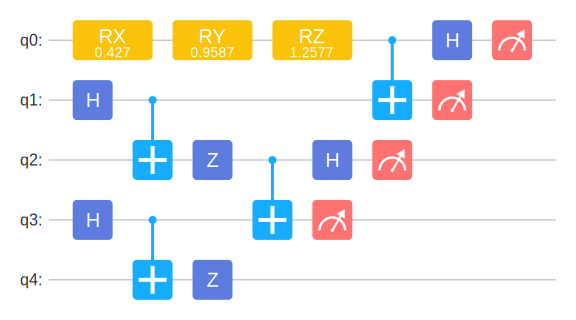

measure result:
q0 = 1, q1 = 0

send state ¦qn,...,q0⟩:
(0.7587523655071231-0.4310464601007012j)¦0⟩
(0.4750830278097279+0.11309250089701395j)¦1⟩

recv state ¦qn,...,q0⟩:
(0.7587523655071229-0.43104646010070113j)¦00101⟩
(0.4750830278097278+0.11309250089701392j)¦10101⟩



In [7]:
def simulate_fig5():
    """复现 Fig.5 线路"""
    cir_send = create_random_state(0)     # the send state |y>
    cir_epr1 = create_EPR_state(1, 2)     # EPR Pair [A2, C1]
    cir_epr2 = create_EPR_state(3, 4)     # EPR Pair [C2, B]
    cir_mod01 = create_basic_module(0, 1)
    cir_mod23 = create_basic_module(2, 3)

    cir_all = cir_send + cir_epr1 + cir_epr2 + cir_mod01

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff)

    ## 第一次测量
    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0, q1测量结果，保存在c0, c1
    c0, c1 = get_measure_result(ket_str, [0, 1])
    # 根据测量结果判断是否加入 X 或 Z 门
    if c1 == '1':
        cir_all += X(2)
    if c0 == '1':
        cir_all += Z(2)

    ## 第二次测量
    cir_all += cir_mod23 # 加上第2部分测量
    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q2, q3测量结果，保存在c2, c3
    c2, c3 = get_measure_result(ket_str, [2, 3])
    # 根据测量结果判断是否加入 X 或 Z 门
    if c3 == '1':
        cir_all += X(4)
    if c2 == '1':
        cir_all += Z(4)

    print(f'Fig.5\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'measure result:\nq0 = {c0}, q1 = {c1}\n')
    print(f'send state ¦qn,...,q0⟩:\n{cir_send.get_qs(ket=True, seed=seed)}\n')
    print(f'recv state ¦qn,...,q0⟩:\n{cir_all.get_qs(ket=True, seed=seed)}\n')


simulate_fig5()

---

### 案例3

- Fig.6 在源节点和宿节点之间通过一个中间节点节点共享EPR对

<img src="images/fig6.jpg" width=400>

Fig.6
complete circuit:



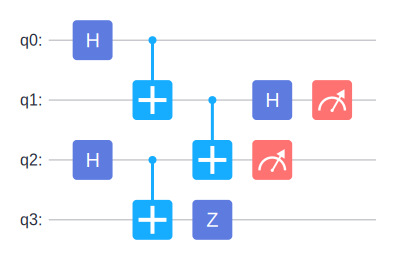

measure result:
q1 = 1, q2 = 0

recv state ¦qn,...,q0⟩:
√2/2¦0010⟩
√2/2¦1011⟩



In [9]:
def simulate_fig6():
    cir_epr1 = create_EPR_state(0, 1) # EPR Pair [A, C1]
    cir_epr2 = create_EPR_state(2, 3) # EPR Pair [C2, B]
    cir_mod12 = create_basic_module(1, 2)
    cir_all = cir_epr1 + cir_epr2 + cir_mod12

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff) # 随机数种子

    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0, q1测量结果，保存在c0, c1
    c1, c2 = get_measure_result(ket_str, [1, 2])
    # 根据测量结果判断是否加入 X 或 Z 门
    if c2 == '1':
        cir_all += X(3)
    if c1 == '1':
        cir_all += Z(3)

    print(f'Fig.6\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'measure result:\nq1 = {c1}, q2 = {c2}\n')
    print(f'recv state ¦qn,...,q0⟩:\n{cir_all.get_qs(ket=True, seed=seed)}\n')

simulate_fig6()
# |0xx0> + |1xx1>

### 案例4

- Fig.8 使用EPR桥接传输单个量子态

<img src="images/fig8.jpg" width=400>

Fig.8
complete circuit:



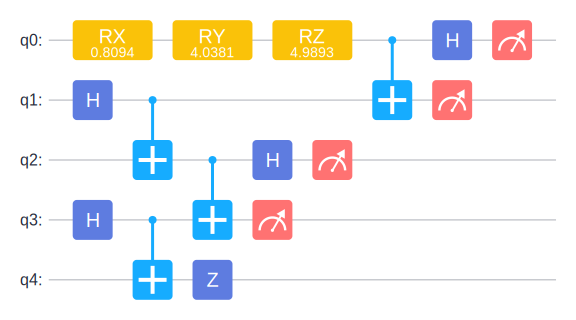

measure result:
q3=0, q2=0, q1=0, q0=1

send state ¦qn,...,q0⟩:
(0.5317769838094857-0.04298993988258498j)¦0⟩
(-0.7638590799214289+0.3631589329494264j)¦1⟩

recv state ¦qn,...,q0⟩:
(0.5317769838094857-0.042989939882584996j)¦00001⟩
(-0.763859079921429+0.36315893294942647j)¦10001⟩



In [11]:
def simulate_fig8():
    cir_send = create_random_state(0)
    cir_epr12 = create_EPR_state(1, 2)
    cir_epr34 = create_EPR_state(3, 4)
    cir_mod23 = create_basic_module(2, 3)
    cir_mod01 = create_basic_module(0, 1)

    cir_all = cir_send + cir_epr12 + cir_epr34 + cir_mod23

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff)

    ## 第一次测量
    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q2, q3测量结果，保存在c2, c3
    c2, c3 = get_measure_result(ket_str, [2, 3])
    # 根据测量结果判断是否加入 X 或 Z 门
    if c3 == '1':
        cir_all += X(4)
    if c2 == '1':
        cir_all += Z(4)

    ## 第二次测量
    cir_all += cir_mod01 # 加上第2部分测量
    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0, q2测量结果，保存在c0, c1
    c0, c1 = get_measure_result(ket_str, [0, 1])
    # 根据测量结果判断是否加入 X 或 Z 门
    if c1 == '1':
        cir_all += X(4)
    if c0 == '1':
        cir_all += Z(4)

    print(f'Fig.8\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'measure result:\nq3={c3}, q2={c2}, q1={c1}, q0={c0}\n')
    print(f'send state ¦qn,...,q0⟩:\n{cir_send.get_qs(ket=True, seed=seed)}\n')
    print(f'recv state ¦qn,...,q0⟩:\n{cir_all.get_qs(ket=True, seed=seed)}\n')


simulate_fig8()

### 案例5

- Fig.9 实现量子路由机制的量子线路

<img src="images/fig9.jpg" width=400>

Fig.9
complete circuit:



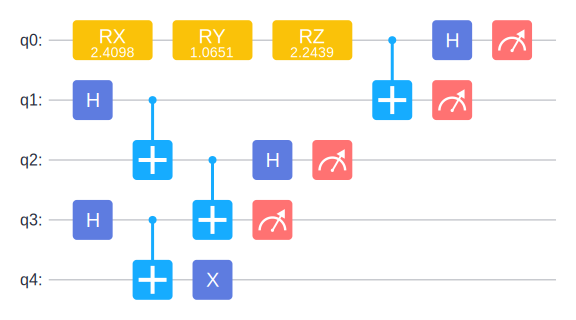

Measure result:
q3=0, q2=0, q1=1, q0=0

Send state ¦qn,...,q0⟩:
(0.5609078399795123-0.07199547988470448j)¦0⟩
(0.8036306917025748-0.18540970114675784j)¦1⟩

Recv state ¦qn,...,q0⟩:
(0.5609078399795128-0.07199547988470453j)¦00010⟩
(0.8036306917025755-0.18540970114675795j)¦10010⟩



In [12]:
def simulate_fig9():
    cir_send = create_random_state(0)
    cir_epr12 = create_EPR_state(1, 2)
    cir_epr34 = create_EPR_state(3, 4)
    cir_mod01 = create_basic_module(0, 1)
    cir_mod23 = create_basic_module(2, 3)

    cir_all = cir_send + cir_epr12 + cir_epr34 + cir_mod01 + cir_mod23

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff) # 随机数种子

    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0-q3测量结果，保存在c0-c3
    c0, c1, c2, c3 = get_measure_result(ket_str, [0, 1, 2, 3])
    a1, a2, cc1, cc2 = c0, c1, c2, c3
    # 根据测量结果判断是否加入 X 或 Z 门
    if a2 != cc2: # XOR
        cir_all += X(4)
    if a1 != cc1: # XOR
        cir_all += Z(4)

    print(f'Fig.9\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'Measure result:\nq3={c3}, q2={c2}, q1={c1}, q0={c0}\n')
    print(f'Send state ¦qn,...,q0⟩:\n{cir_send.get_qs(ket=True, seed=seed)}\n')
    print(f'Recv state ¦qn,...,q0⟩:\n{cir_all.get_qs(ket=True, seed=seed)}\n')


simulate_fig9()

---

### 案例6

- Fig.13 Alice和Bob在同一个QBK范围内的量子线路

<img src="images/fig13.jpg" width=400>

Fig.13
complete circuit:



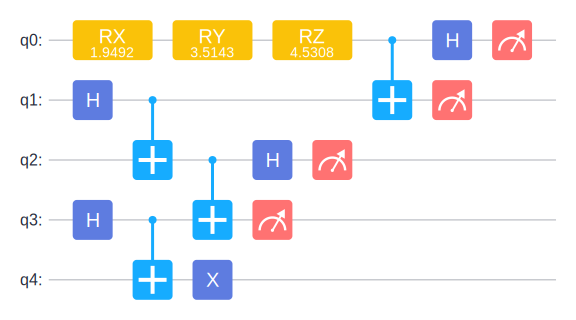

Measure result:
q3=0, q2=0, q1=1, q0=0

Send state ¦qn,...,q0⟩:
(0.6913383362651505-0.44053791923099206j)¦0⟩
(-0.4709942258759291+0.3257945452601929j)¦1⟩

Recv state ¦qn,...,q0⟩:
(0.6913383362651504-0.4405379192309919j)¦00010⟩
(-0.47099422587592904+0.32579454526019286j)¦10010⟩



In [13]:
def simulate_fig13():
    """same to fig9"""
    cir_send = create_random_state(0)
    cir_epr12 = create_EPR_state(1, 2)
    cir_epr34 = create_EPR_state(3, 4)
    cir_mod01 = create_basic_module(0, 1)
    cir_mod23 = create_basic_module(2, 3)

    cir_all = cir_send + cir_epr12 + cir_epr34 + cir_mod01 + cir_mod23

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff)

    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0-q3测量结果，保存在c0-c3
    c0, c1, c2, c3 = get_measure_result(ket_str, [0, 1, 2, 3])
    a1, a2, cc1, cc2 = c0, c1, c2, c3
    # 根据测量结果判断是否加入 X 或 Z 门
    if a2 != cc2:  # XOR
        cir_all += X(4)
    if a1 != cc1:  # XOR
        cir_all += Z(4)

    print(f'Fig.13\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'Measure result:\nq3={c3}, q2={c2}, q1={c1}, q0={c0}\n')
    print(f'Send state ¦qn,...,q0⟩:\n{cir_send.get_qs(ket=True, seed=seed)}\n')
    print(f'Recv state ¦qn,...,q0⟩:\n{cir_all.get_qs(ket=True, seed=seed)}\n')


simulate_fig13()

### 案例7

- Fig.14 Alice和Bob在不同QBK域内时的量子线路

<img src="images/fig14.jpg" width=400>

Fig.14
complete circuit:



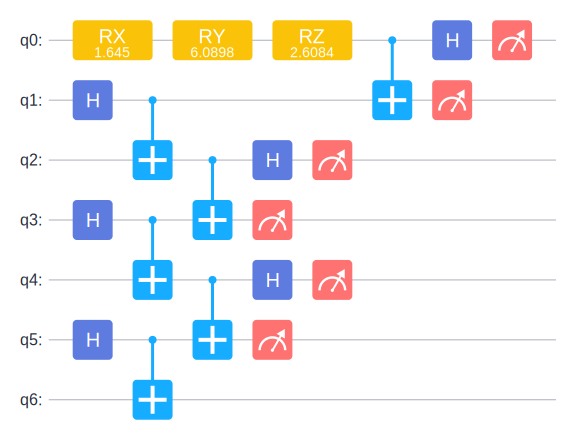

Measure result:
q5=1, q4=1, q3=0, q2=0, q1=1, q0=1

Send state ¦qn,...,q0⟩:
(-0.11013842684602972+0.6719143380846326j)¦0⟩
(-0.6863639707062489+0.2555487212343731j)¦1⟩

Recv state ¦qn,...,q0⟩:
(0.11013842684602969-0.6719143380846326j)¦0110011⟩
(0.6863639707062489-0.255548721234373j)¦1110011⟩



In [14]:
def simulate_fig14():
    """复现 Fig.14 线路"""
    cir_send = create_random_state(0)  # the send state
    cir_epr12 = create_EPR_state(1, 2)
    cir_epr34 = create_EPR_state(3, 4)
    cir_epr56 = create_EPR_state(5, 6)

    cir_mod01 = create_basic_module(0, 1)
    cir_mod23 = create_basic_module(2, 3)
    cir_mod45 = create_basic_module(4, 5)

    cir_all = cir_send + cir_epr12 + cir_epr34 + cir_epr56 +\
                cir_mod01 + cir_mod23 + cir_mod45

    # 使用同一个随机数种子，避免各次测量结果不同
    seed = np.random.randint(0, 0xff)

    # get_qs 不会改变系统状态
    ket_str = cir_all.get_qs(ket=True, seed=seed)
    # 获取q0-q3测量结果，保存在c0-c3
    c0, c1, c2, c3, c4, c5 = get_measure_result(ket_str, [0, 1, 2, 3, 4, 5])
    # 根据测量结果判断是否加入 X 或 Z 门
    i0, i1, i2, i3, i4, i5 = int(c0), int(c1), int(c2), \
                                int(c3), int(c4), int(c5)
    if i1+i3+i5 in [1, 3]:  # XOR
        cir_all += X(6)
    if i0+i2+i4 in [1, 3]:  # XOR
        cir_all += Z(6)

    print(f'Fig.14\ncomplete circuit:\n')
    display_svg(cir_all.svg())
    print(f'Measure result:\nq5={c5}, q4={c4}, q3={c3}, q2={c2}, q1={c1}, q0={c0}\n')
    print(f'Send state ¦qn,...,q0⟩:\n{cir_send.get_qs(ket=True, seed=seed)}\n')
    print(f'Recv state ¦qn,...,q0⟩:\n{cir_all.get_qs(ket=True, seed=seed)}\n')


simulate_fig14()